## Creating data for our model

In [6]:
!pip install import-ipynb

  Running setup.py bdist_wheel for import-ipynb: started
  Running setup.py bdist_wheel for import-ipynb: finished with status 'done'
  Stored in directory: C:\Users\Paridhi\AppData\Local\pip\Cache\wheels\b4\7b\e9\a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [7]:
import import_ipynb
import my_utils

importing Jupyter notebook from my_utils.ipynb


In [39]:
%run my_utils.ipynb

In [9]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
# from my_utils import *
%matplotlib inline

In [10]:
IPython.display.Audio("./raw_data/activates/2.wav")

In [11]:
IPython.display.Audio("./raw_data/negatives/4.wav")

In [12]:
IPython.display.Audio("./raw_data/backgrounds/1.wav")

In [13]:
IPython.display.Audio("audio_examples/example_train.wav")

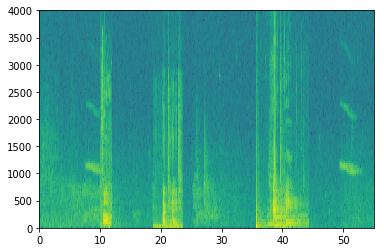

In [40]:
x = graph_spectrogram("audio_examples/example_train.wav")

In [41]:
_, data = wavfile.read("audio_examples/example_train.wav")
print("Time steps in audio recording before spectrogram", data[:,0].shape)
print("Time steps in input after spectrogram", x.shape)

Time steps in audio recording before spectrogram (441000,)
Time steps in input after spectrogram (101, 5511)


In [42]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

In [43]:
# Load audio segments using pydub 
activates, negatives, backgrounds = load_raw_audio()

print("background len: " + str(len(backgrounds[0])))    # Should be 10,000, since it is a 10 sec clip
print("activate[0] len: " + str(len(activates[0])))     # Maybe around 1000, since an "activate" audio clip is usually around 1 sec (but varies a lot)
print("activate[1] len: " + str(len(activates[1])))     # Different "activate" clips can have different lengths

background len: 10000
activate[0] len: 721
activate[1] len: 731


In [44]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [45]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True

    return overlap

In [46]:
overlap1 = is_overlapping((950, 1430), [(2000, 2550), (260, 949)])
overlap2 = is_overlapping((2305, 2950), [(824, 1532), (1900, 2305), (3424, 3656)])
print("Overlap 1 = ", overlap1)
print("Overlap 2 = ", overlap2)

Overlap 1 =  False
Overlap 2 =  True


In [47]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
   
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [48]:
np.random.seed(5)
audio_clip, segment_time = insert_audio_clip(backgrounds[0], activates[0], [(3790, 4400)])
audio_clip.export("insert_test.wav", format="wav")
print("Segment Time: ", segment_time)
IPython.display.Audio("insert_test.wav")

Segment Time:  (2915, 3635)


In [49]:
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1

    
    return y

sanity checks: 0.0 1.0 0.0


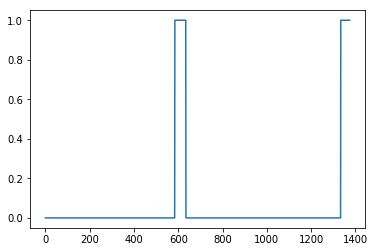

In [50]:
arr1 = insert_ones(np.zeros((1, Ty)), 9700)
plt.plot(insert_ones(arr1, 4251)[0,:])
print("sanity checks:", arr1[0][1333], arr1[0][634], arr1[0][635])

In [51]:
def create_training_example(background, activates, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    np.random.seed(18)
    
    # Make background quieter
    background = background - 20

    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
    print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram("train.wav")
    
    return x, y

File (train.wav) was saved in your directory.


C:\Users\Paridhi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


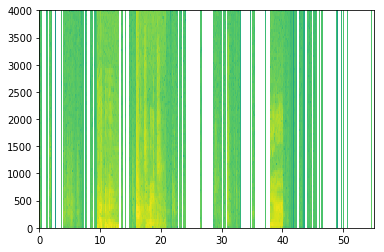

In [52]:
x, y = create_training_example(backgrounds[0], activates, negatives)

In [53]:
IPython.display.Audio("train.wav")

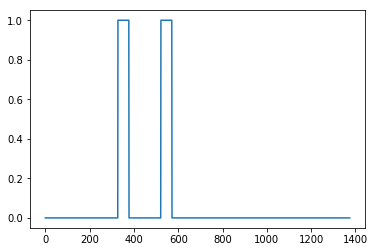

In [54]:
#Finally, you can plot the associated labels for the generated training example.

plt.plot(y[0])

In [55]:
# Load preprocessed training examples
X = np.load("./Data/XY_train/X.npy")
Y = np.load("./Data/XY_train/Y.npy")

In [56]:
# Load preprocessed dev set examples
X_dev = np.load("./Data/XY_dev/X_dev.npy")
Y_dev = np.load("./Data/XY_dev/Y_dev.npy")